In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt

from extra_data import open_run
from data_utils import load_trains, load_trains_pool

## Creating a json config file

I use JSON files to save the config data used in loading the data. A configuration file contains the following information:

- `data_type` : Choose between 'raw' and 'proc'.
- `geom_path` : A path to the JUNGFRAU geometry ('.geom') file.
- `modules` : Number of detector modules to load.
- `pattern` : Regex to find the module number in source names. Should contain a group
  which can be converted to an integer. E.g. ``r'/DET/JNGFR(\\d+)'`` for
  one JUNGFRAU naming convention.
- `sources` : glob patterns to select the JUNGFRAU detector sources.
- `starts_at` : By default, uses module numbers starting at 0 (e.g. 0-15 inclusive).
  If the numbering is e.g. 1-16 instead, pass ``starts_at = 1``.

In [15]:
PROPOSAL = 4456
DATA_TYPE = 'proc'
SOURCES = (('SPB_IRDA_JF4M/DET/JNGFR*:daqOutput', 'data.adc'),
           ('SPB_IRDA_JF4M/DET/JNGFR*:daqOutput', 'data.gain'),
           ('SPB_IRDA_JF4M/DET/JNGFR*:daqOutput', 'data.mask'))
PATTERN = r'SPB_IRDA_JF4M/DET/JNGFR(\d+)'
START_INDEX = 1
N_MODULES = 8
GEOM_PATH = '/gpfs/exfel/exp/SPB/202302/p004456/usr/geometry/geom_v5.geom'

CONFIG = {'proposal': PROPOSAL,
          'data_type': DATA_TYPE,
          'sources': SOURCES,
          'starts_at': START_INDEX,
          'modules': N_MODULES,
          'pattern': PATTERN,
          'geom_path': GEOM_PATH}

config = json.JSONDecoder().decode(json.dumps(CONFIG))

with open('test.json', 'w') as file:
    json.dump(config, file, sort_keys=True, ensure_ascii=False, indent=4)

In [3]:
# I've attached two config files: default.json and adc_only.json
# - default.json : Load data.adc, data.gain, and data.mask
# - adc_only.json : Load data.adc only

with open('configs/adc_only.json', 'r') as file:
    config = json.load(file)

## Loading data

In [8]:
# Select run number
run_num = 15

# Open run with extra_data
run = open_run(proposal=config['proposal'], run=run_num, data=config['data_type'])
sel = run.select(config['sources'])

# Select a list of trains to load, you need to parse train_ids to load_trains
trains = sel.train_ids[::10]

# Load trains 
data = load_trains(sel, trains, config)

# OR load trains concurrently (will work faster ONLY when the ammount of data
# loaded is comparatively low)
data = load_trains_pool(sel, trains, config, stacked=False, roi=(1000, 1750, 500, 1250), processes=64)

Reading run:   0%|          | 0/50 [00:00<?, ?it/s]

Reading run:   0%|          | 0/50 [00:00<?, ?it/s]

In [9]:
data['assembled']['data.adc'].shape

(50, 750, 750)

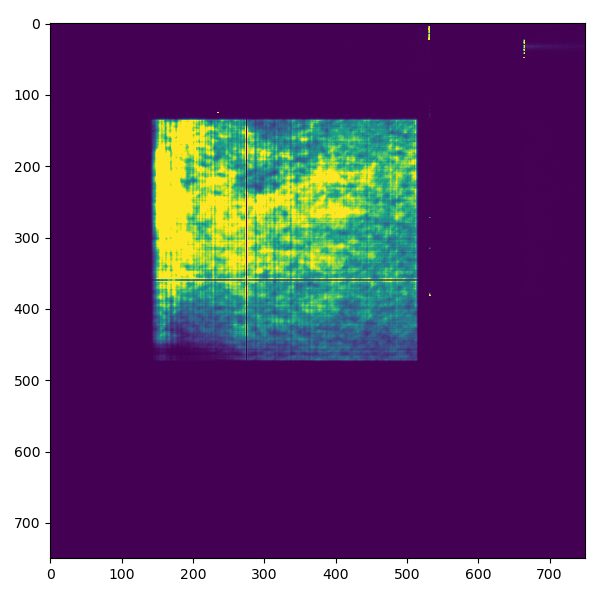

In [10]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(np.sum(data['assembled']['data.adc'], axis=0), vmin=0, vmax=10000)

fig.tight_layout()
plt.show()